# jointcal astrometric residual plots

This notebook contains a collection of debugging plots for jointcal's internal astrometric residual values. These are not "publication quality" plots, but some may be turned into better QA plots later on.

In [1]:
%matplotlib notebook
%config InlineBackend.figure_format = 'retina'

import itertools

import astropy.io.ascii
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import numpy as np
matplotlib.rcParams['savefig.dpi'] = 120
matplotlib.rcParams['figure.dpi'] = 120
sns.set_style("ticks")
sns.set_context("notebook", font_scale=1.3, rc={"lines.linewidth": 2.5})

In [2]:
def colorbar(mappable, pad=0.05):
    """Stolen from: http://joseph-long.com/writing/colorbars/"""
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=pad)
    return fig.colorbar(mappable, cax=cax)

In [3]:
# because we don't have astropy units on the .csv output.
deg_to_arcsec = 60. * 60.
deg_to_mas = 60. * 60. * 1e3

## data

Read in the chi2 contributions files output by jointcal and extract the unique visits.

To produce these files, set `config.writeChi2ContributionFiles=True` when running jointcal. The built-in example plots here are from running `JointcalTestCFHT.test_jointcalTask_2_visits_constrainedPoly` with that config turned on. It will also generate `astrometry_*_chi2-TRACT_FILTER-ref.csv` files, which contain the residuals measured against the reference stars.

Residual in this context means "difference between measuredStar its fittedStar". See `AstrometryFit.saveChi2MeasContributions()` for exactly how the values are calcuated.

In [4]:
initial = astropy.io.ascii.read('../tests/astrometry_initial_chi2-0_r-meas.csv')
final = astropy.io.ascii.read('../tests/astrometry_final_chi2-0_r-meas.csv')
# Uncomment the below to use the validation_data_hsc output (4 visits)
# initial = astropy.io.ascii.read('/data/validate/jointcal-hsc/astrometry_initial_chi2-0_i-meas.csv')
# final = astropy.io.ascii.read('/data/validate/jointcal-hsc/astrometry_final_chi2-0_i-meas.csv')

for col,comment in zip(initial.colnames, initial.meta['comments'][0].split('\t')):
    print("%s: %s"%(col, comment))
print()

visits = np.unique(final['visit'])
chips = np.unique(final['chip'])

print(visits)
print()
print(chips)

id: id in source catalog
xccd: coordinates in CCD (pixels)
yccd: 
rx: residual on TP (degrees)
ry: 
xtp: transformed coordinate in TP (degrees)
ytp: 
mag: rough magnitude
mjd: Modified Julian Date of the measurement
xErr: transformed measurement uncertainty (degrees)
yErr: 
xyCov: 
xtpi: as-read position on TP (degrees)
ytpi: 
rxi: as-read residual on TP (degrees)
ryi: 
color: currently unused
fsindex: unique index of the fittedStar
ra: on sky position of fittedStar
dec: 
chi2: contribution to Chi2 (2D dofs)
nm: number of measurements of this fittedStar
chip: chip id
visit: visit id

visit 
------
849375
850587

chip
----
  12
  13
  14
  21
  22
  23


## basic histograms

If jointcal is operating correctly, the final astrometric residuals (`rx`, `ry`, `hypot(rx,ry)`) should be markedly more peaked toward 0 than the initial residuals (`rxi`, `ryi`, `hypot(rxi,ryi)`) computed from the read-in WCS.

Note that we have to compare e.g. `final['rx']` with `initial['rxi']`, instead of `final['rxi']` because the final values are computed against the final positions of the `fittedStars` whereas the initial values are computed against the average of the as-read star positions. Similarly, `initial['rx']` is not a very informative residual because our model may not be a good match to the per-CCD FITS-SIP WCS that is fit by `singleFrameTask`.

In [29]:
def residual_histogram(initial, final, cut=100, xlabel='residual (mas)'):
    """Plot histograms of initial and final residuals, around +/-cut milliarcsec"""
    plt.figure()
    palette = itertools.cycle(sns.color_palette())

    color = next(palette)
    sns.distplot(initial[(-cut < initial) & (initial < cut)], label='initial')
    plt.axvline(np.median(initial), linestyle='dashed', linewidth=2, c=color)

    color = next(palette)
    sns.distplot(final[(-cut < final) & (final < cut)], label='final')
    plt.axvline(np.median(final), linestyle='dashed', linewidth=2, c=color)

    plt.xlabel(xlabel)
    plt.ylabel('normalized counts')
    plt.legend()
    plt.tight_layout()

<IPython.core.display.Javascript object>


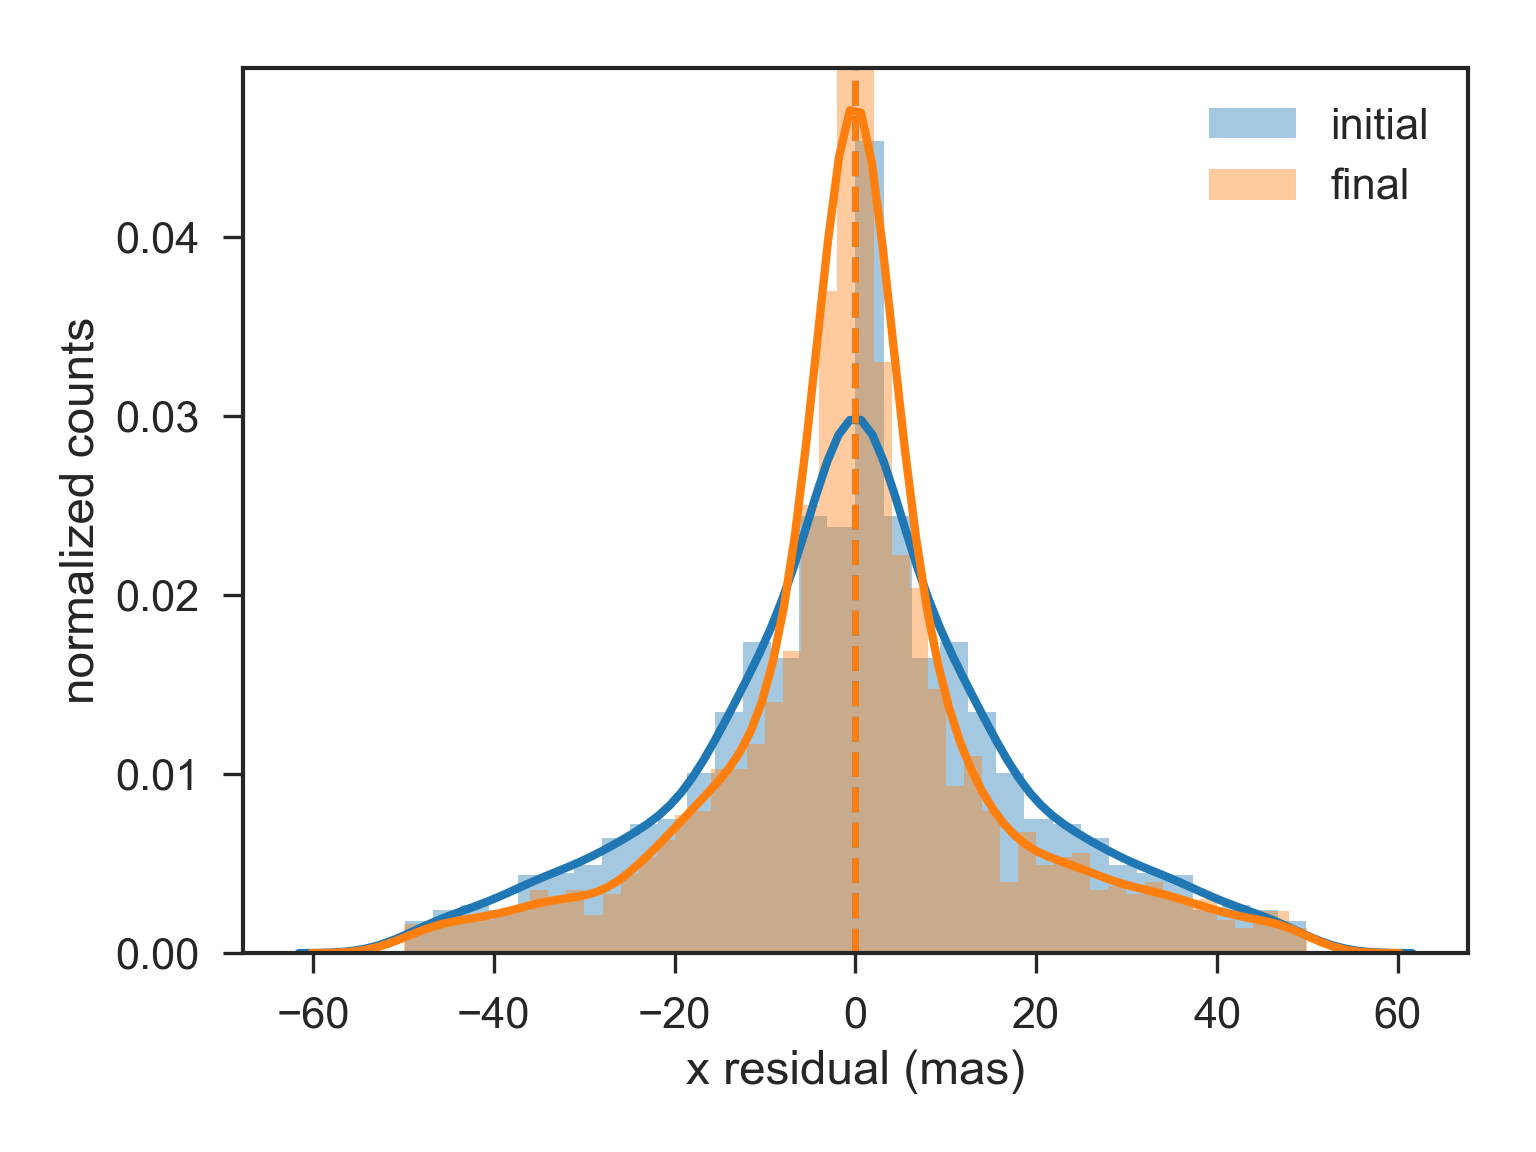

<IPython.core.display.Javascript object>


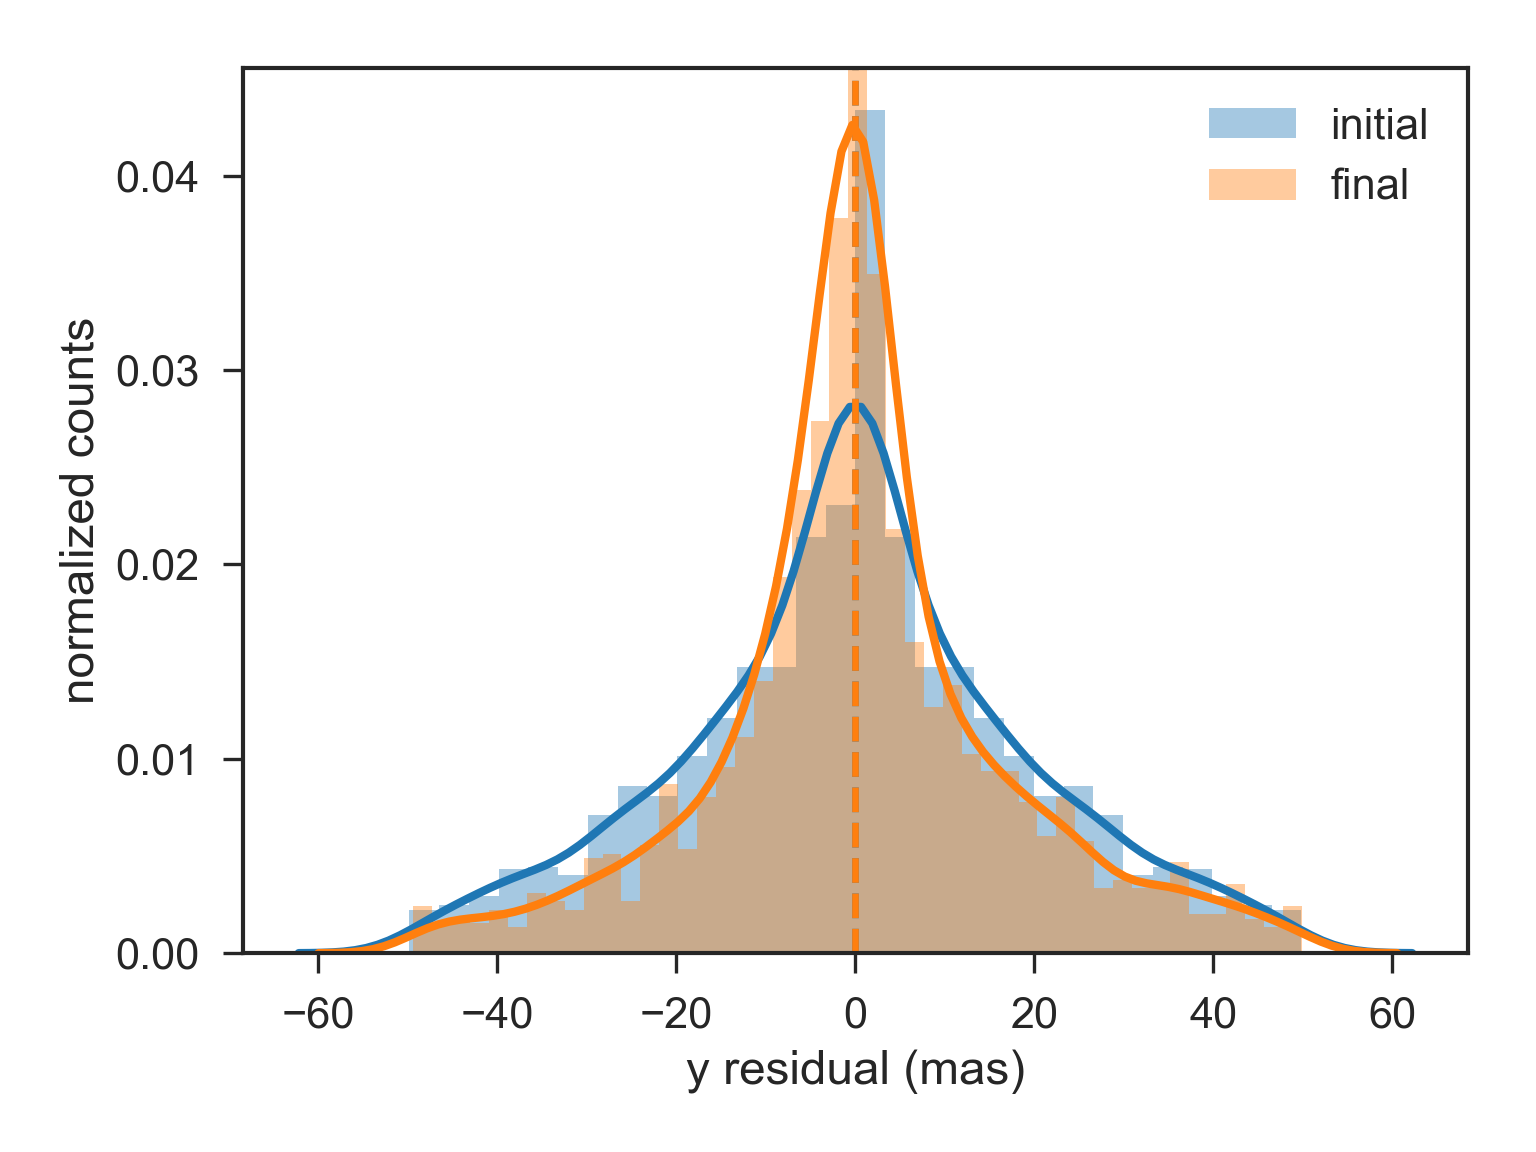

<IPython.core.display.Javascript object>


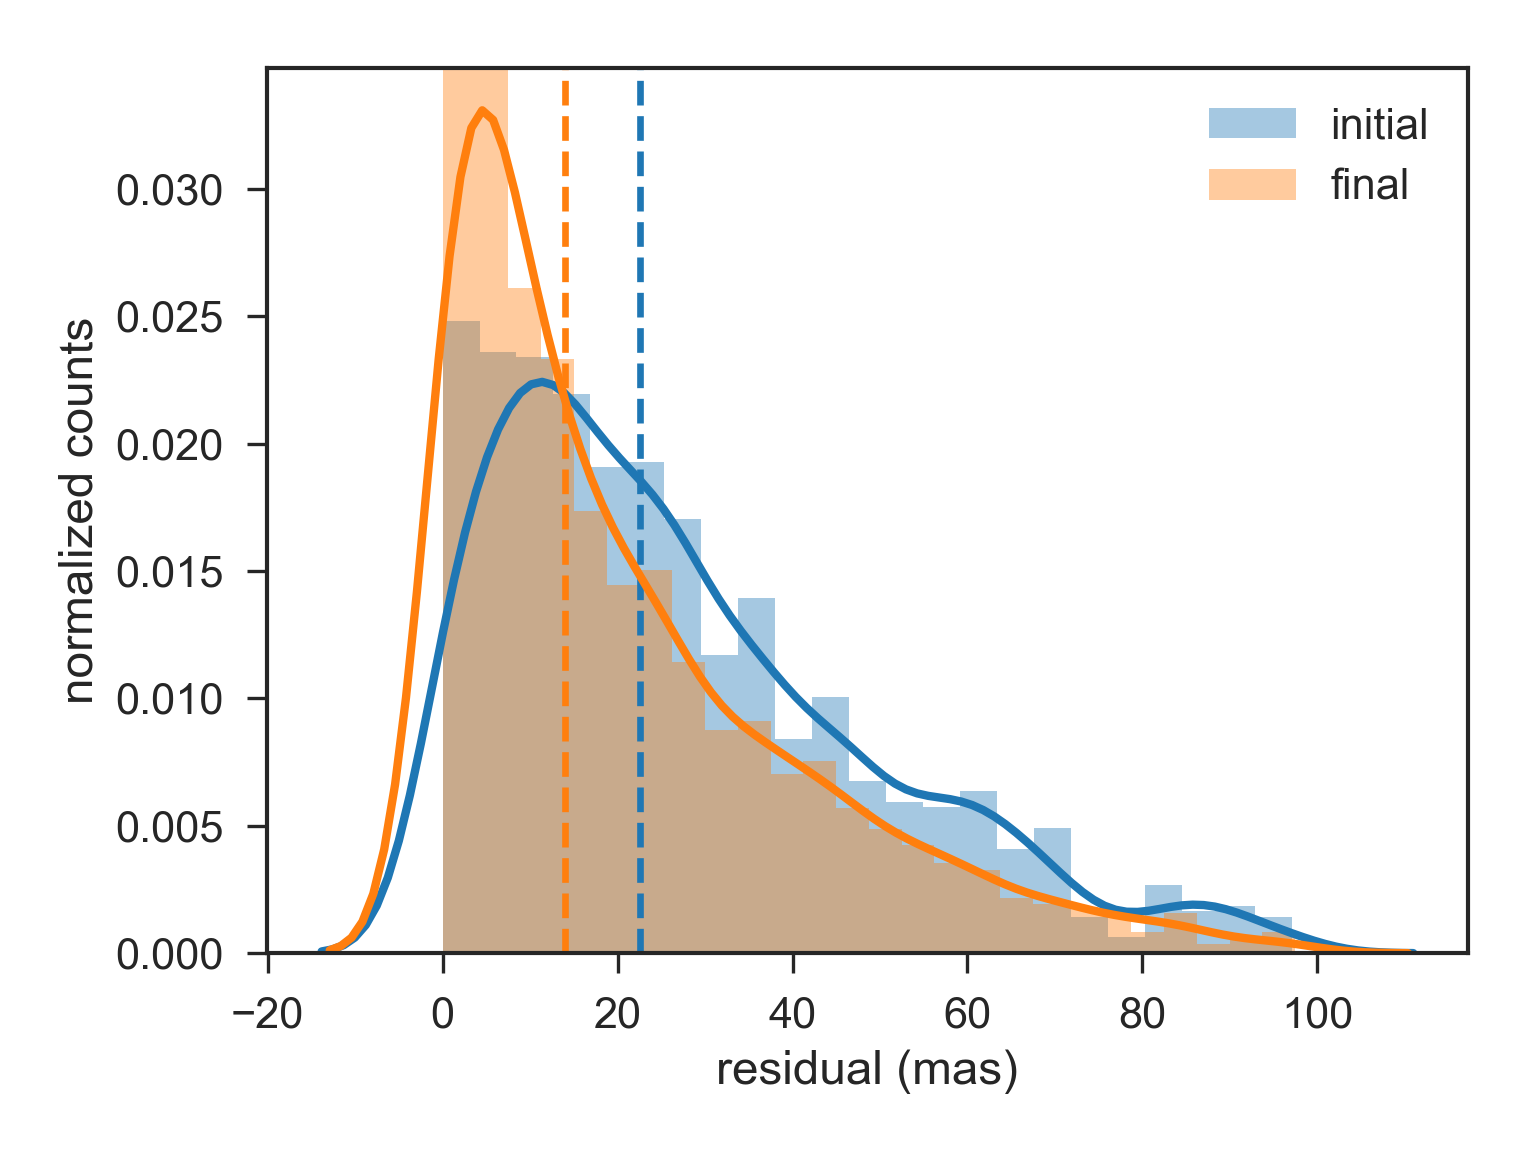

In [30]:
initial_norm = np.hypot(initial['rxi'], initial['ryi'])*deg_to_mas
final_norm = np.hypot(final['rx'], final['ry'])*deg_to_mas

residual_histogram(initial['rxi']*deg_to_arcsec*1e3, final['rx']*deg_to_arcsec*1e3,
                   cut=50, xlabel="x residual (mas)")
residual_histogram(initial['ryi']*deg_to_arcsec*1e3, final['ry']*deg_to_arcsec*1e3,
                   cut=50, xlabel="y residual (mas)")
residual_histogram(initial_norm, final_norm)

## functions

In [7]:
def plot_tangentplane_residual_magnitudes(initial, final):
    """Magnitude of on-sky residuals, input WCS vs. final jointcal fit."""

    for visit in visits:
        # need more than one measurement for these to make sense
        cut1 = initial[(initial['nm'] > 1) & (initial['visit'] == visit)]
        cut2 = final[(final['nm'] > 1) & (final['visit'] == visit)]
        fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=True, sharex=True)

        initial_norm = np.hypot(cut1['rxi'], cut1['ryi'])*deg_to_mas
        final_norm = np.hypot(cut2['rx'], cut2['ry'])*deg_to_mas

        kwargs = dict(vmin=0, vmax=100, gridsize=50)
        axes[0].hexbin(cut1['ra'], cut1['dec'], initial_norm, **kwargs)
        ax = axes[1].hexbin(cut2['ra'], cut2['dec'], final_norm, **kwargs)

        axes[0].set_title('intial')
        axes[1].set_title('final')
        axes[0].set_xlabel("x tangent plane (degrees)")
        axes[1].set_xlabel("x tangent plane (degrees)")
        axes[0].set_ylabel("y tangent plane (degrees)")
        fig.suptitle('visit: %d'%visit)
        cbar = colorbar(ax)
        cbar.set_label('position residual (mas)', rotation=270, labelpad=15)

        fig.tight_layout()
        fig.subplots_adjust(wspace=0)

In [31]:
def plot_tangentplane_residuals(initial, final, scale=1):
    """Quiver plots of on-sky residuals; input WCS vs. final jointcal fit."""
    label_length = 10
    fact = 4e3

    for visit in visits:
        cut1 = initial[(initial['nm'] > 1) & (initial['visit'] == visit)]
        cut2 = final[(final['nm'] > 1) & (final['visit'] == visit)]
        fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=True, sharex=True)

        Q1 = axes[0].quiver(cut1['ra'], cut1['dec'], cut1['rxi'], cut1['ryi'],
                            scale = scale/deg_to_arcsec, units='width', headwidth=4)
        Q2 = axes[1].quiver(cut2['ra'], cut2['dec'], cut2['rx'], cut2['ry'],
                            scale = scale/deg_to_arcsec, units='width', headwidth=4)
        axes[0].quiverkey(Q1, 0.88, 0.97, label_length/deg_to_arcsec/100, '%d mas' %
                         label_length, labelpos='S', coordinates='figure')
        axes[1].quiverkey(Q2, 0.19, 0.97, label_length/deg_to_arcsec/100, '%d mas' %
                         label_length, labelpos='S', coordinates='figure')

        axes[0].set_title('intial')
        axes[1].set_title('final')
        axes[0].set_xlabel("x tangent plane (degrees)")
        axes[1].set_xlabel("x tangent plane (degrees)")
        axes[0].set_ylabel("y tangent plane (degrees)")
        fig.suptitle('visit: %d'%visit)
        fig.tight_layout()
        fig.subplots_adjust(wspace=0)

In [9]:
def plot_mags(initial, final, cut=100):
    """Star magnitude vs. x/y residuals between at +/-cut milliarcsec."""

    cut = cut/deg_to_mas
    for visit in visits:
        cut1_x = initial[(initial['visit'] == visit) & (-cut < initial['rxi']) & (initial['rxi'] < cut)]
        cut1_y = initial[(initial['visit'] == visit) & (-cut < initial['ryi']) & (initial['ryi'] < cut)]
        cut2_x = final[(final['visit'] == visit) & (-cut < final['rx']) & (final['rx'] < cut)]
        cut2_y = final[(final['visit'] == visit) & (-cut < final['ry']) & (final['ry'] < cut)]
        print("%d initial total, cut x/y: %d, %d/%d"%(visit, len(initial), len(cut1_x), len(cut1_y)))
        print("%d final total, cut x/y: %d, %d/%d"%(visit, len(final), len(cut2_x), len(cut2_y)))
        fig, axes = plt.subplots(2, 2, figsize=(8, 8), sharey=True, sharex=True)

        kwargs = dict(mincnt=1, gridsize=50)  # to keep the hexbins somewhat consistent
        
        axes[0,0].hexbin(cut1_x['mag'], deg_to_mas*cut1_x['rxi'], **kwargs)
        axes[0,0].set_ylabel("initial x residual (mas)")
        ax = axes[0,1].hexbin(cut1_y['mag'], deg_to_mas*cut1_y['ryi'], **kwargs)
        axes[0,1].yaxis.set_label_position("right")
        axes[0,1].set_ylabel("initial y residual (mas)")
        cbar = colorbar(ax, pad=0.3)
        cbar.set_label('number per bin', rotation=270, labelpad=15)
        
        axes[1,0].hexbin(cut2_x['mag'], deg_to_mas*cut2_x['rx'], **kwargs)
        axes[1,0].set_ylabel("final x residual (mas)")
        ax = axes[1,1].hexbin(cut2_y['mag'], deg_to_mas*cut2_y['ry'], **kwargs)
        axes[1,1].yaxis.set_label_position("right")
        axes[1,1].set_ylabel("final y residual (mas)")
        cbar = colorbar(ax, pad=0.3)
        cbar.set_label('number per bin', rotation=270, labelpad=15)
        axes[1,0].set_xlabel("magnitude")
        axes[1,1].set_xlabel("magnitude")

        fig.suptitle('visit: %d'%visit)
        fig.tight_layout()
        fig.subplots_adjust(wspace=0, hspace=0, top=0.94)

## Plots

### norm of residuals per visit

The magnitudes of the final position residuals should not have any obvious structure, and should be "flatter" than the initial residuals. How much flatter depends on the number of visits that were included in the fit.

<IPython.core.display.Javascript object>


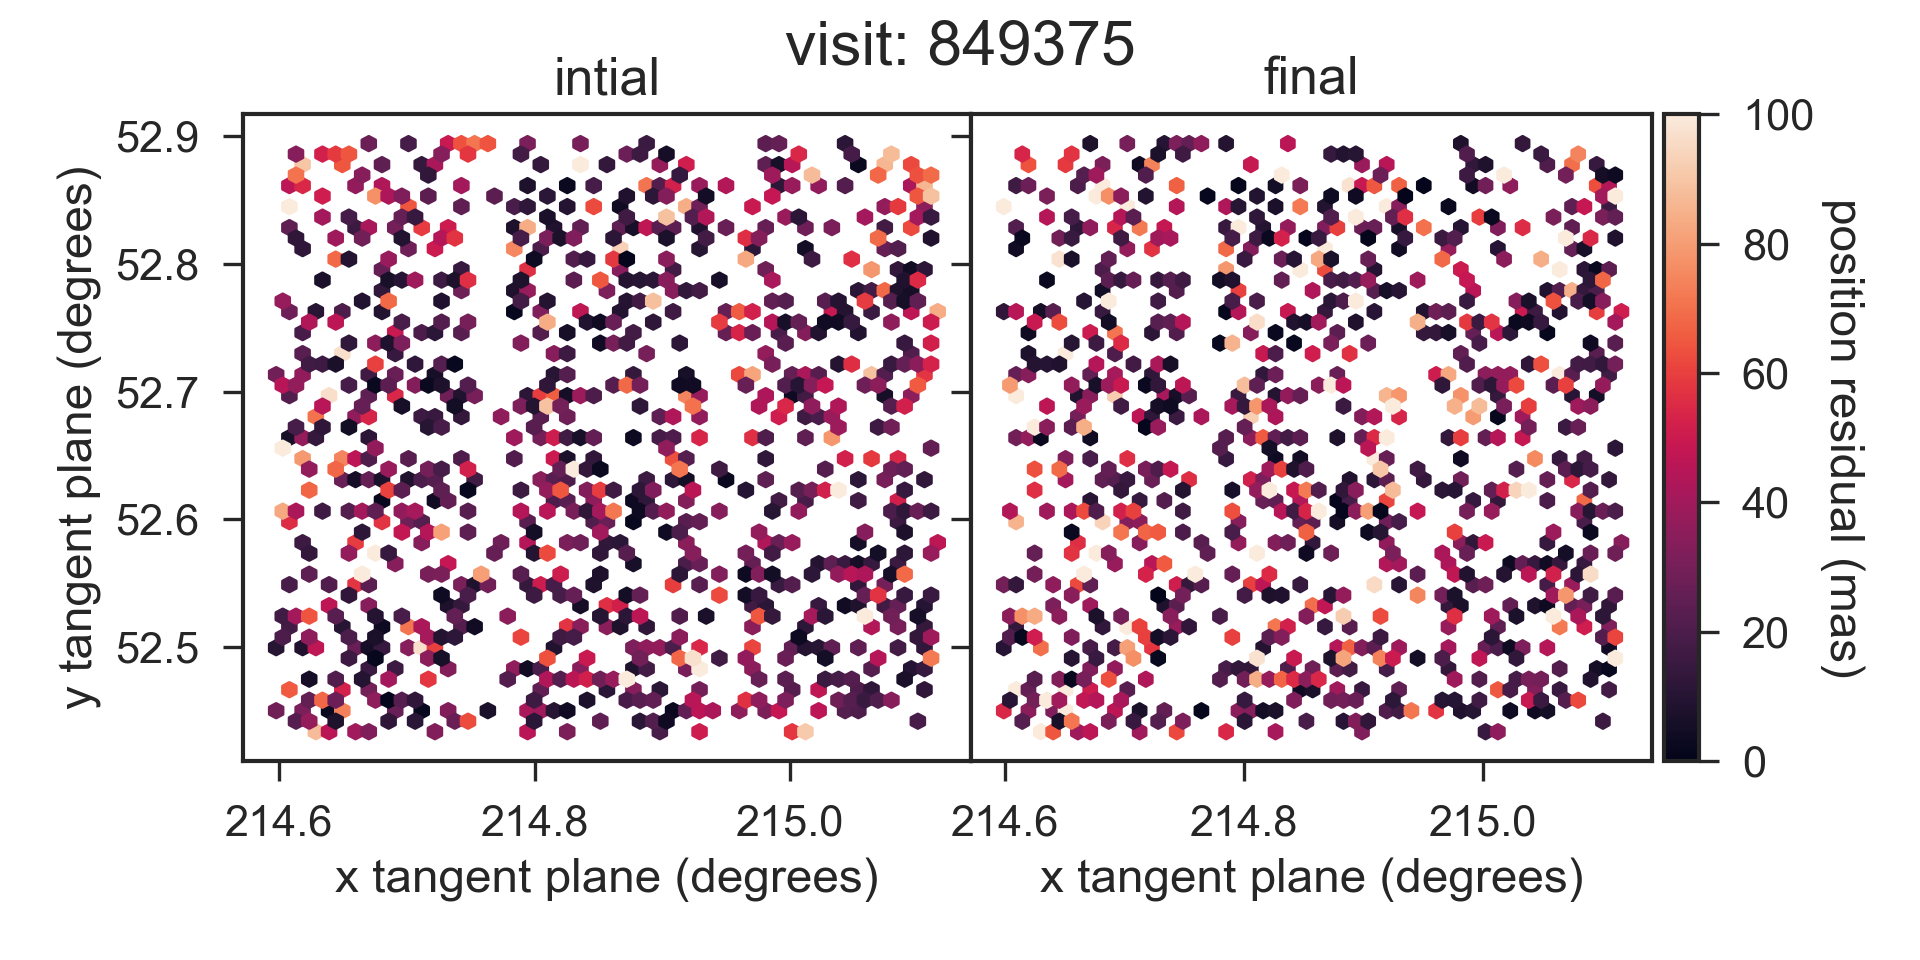

<IPython.core.display.Javascript object>


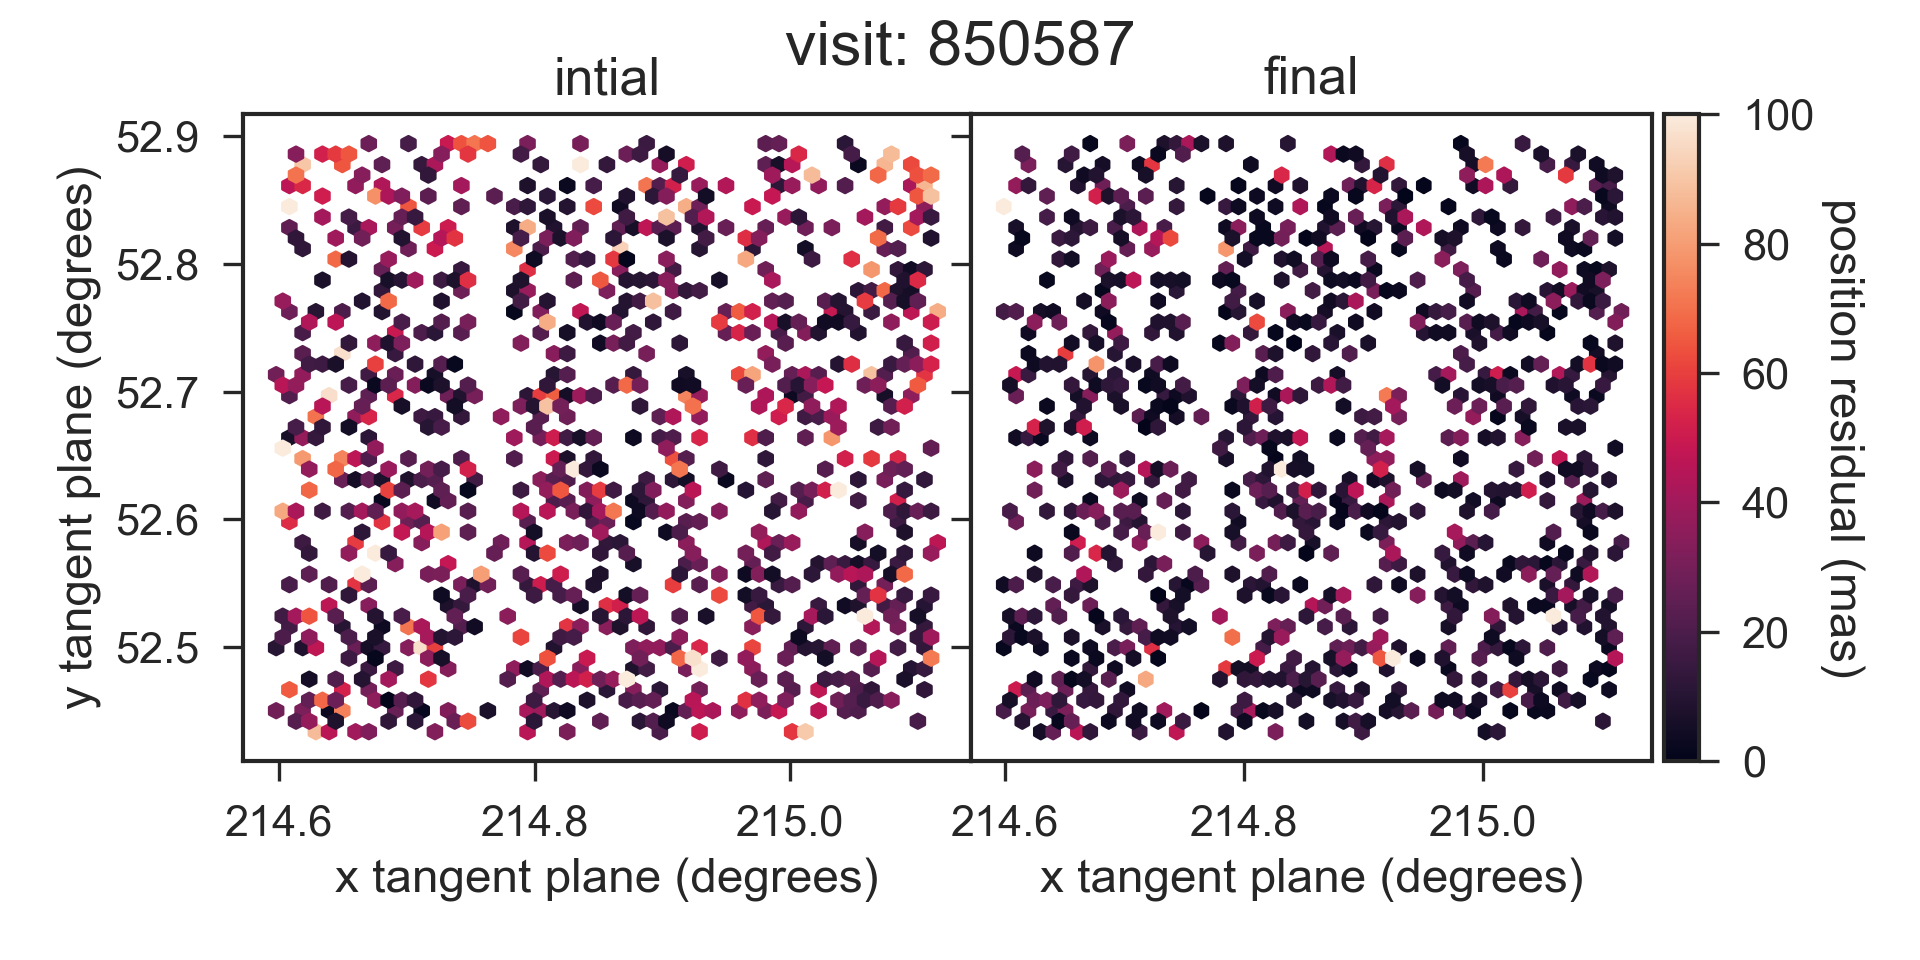

In [10]:
plot_tangentplane_residual_magnitudes(initial, final)

### residuals per visit

Final residuals should be less structured (fewer groups of arrows pointing in the same direction) and should have arrows of somewhat smaller magnitude. How much smaller and how much less structured depends on the number of visits that were included in the fit.

<IPython.core.display.Javascript object>


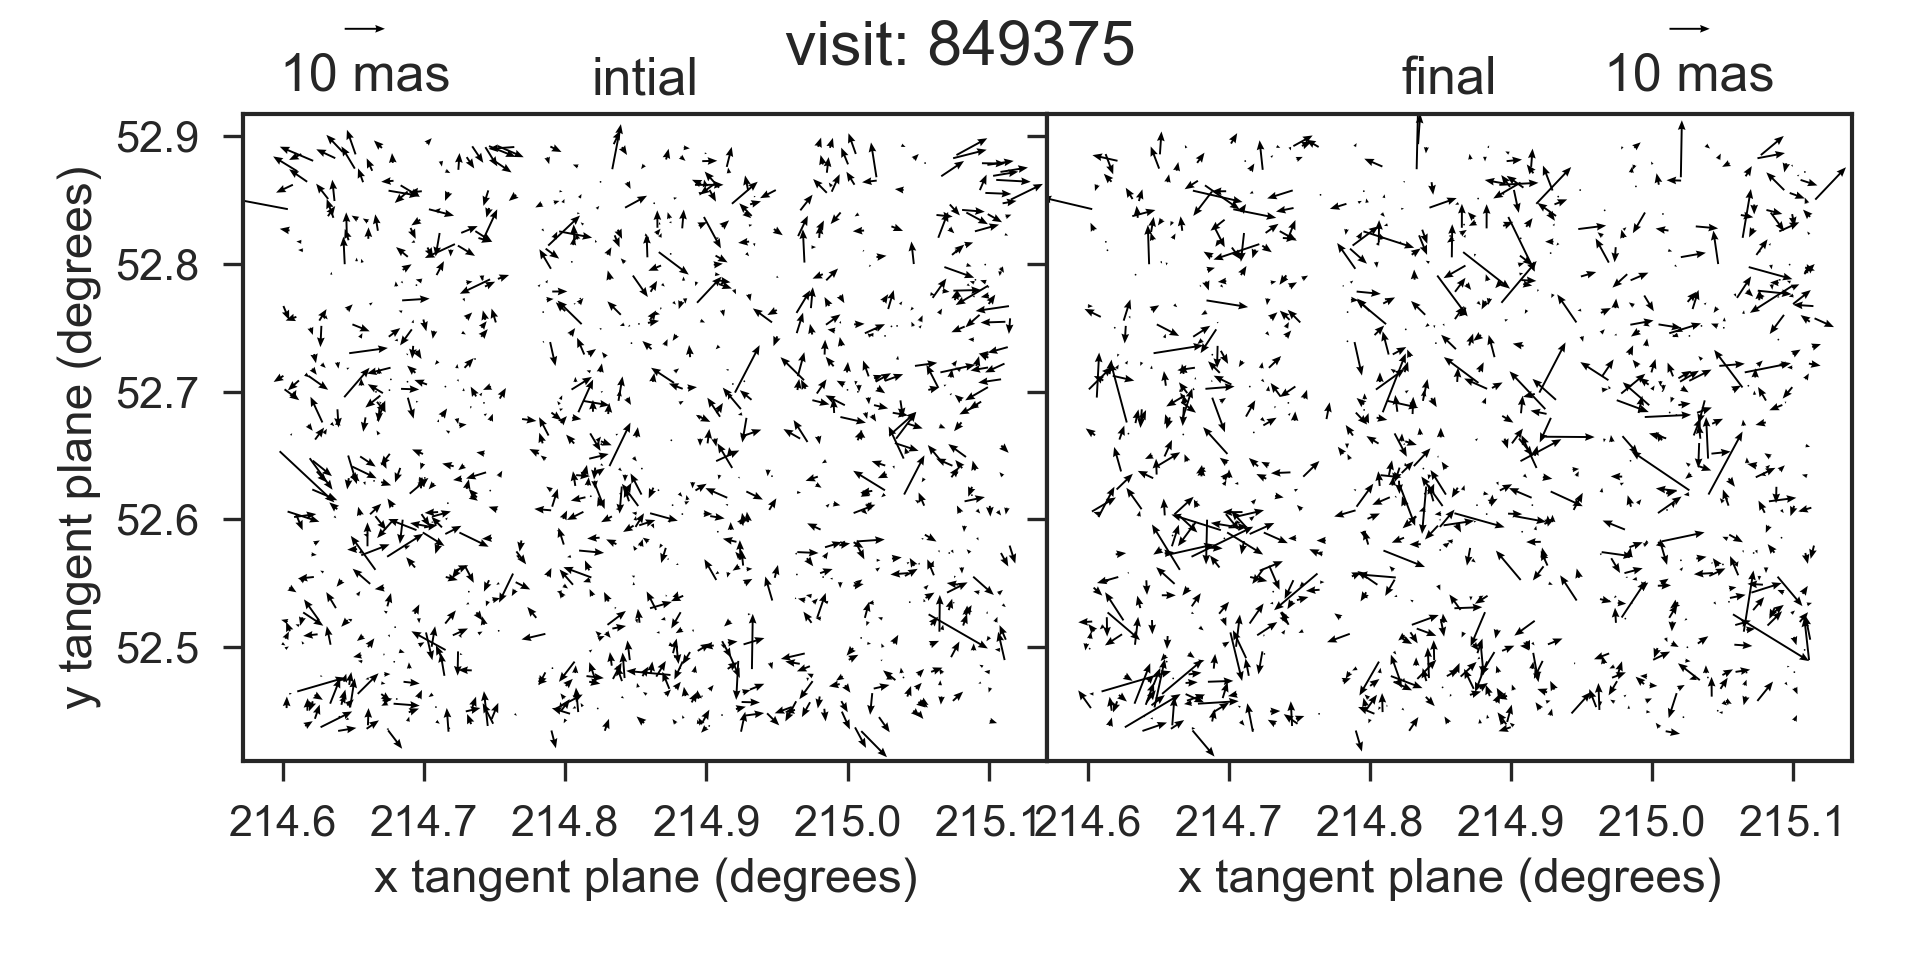

<IPython.core.display.Javascript object>


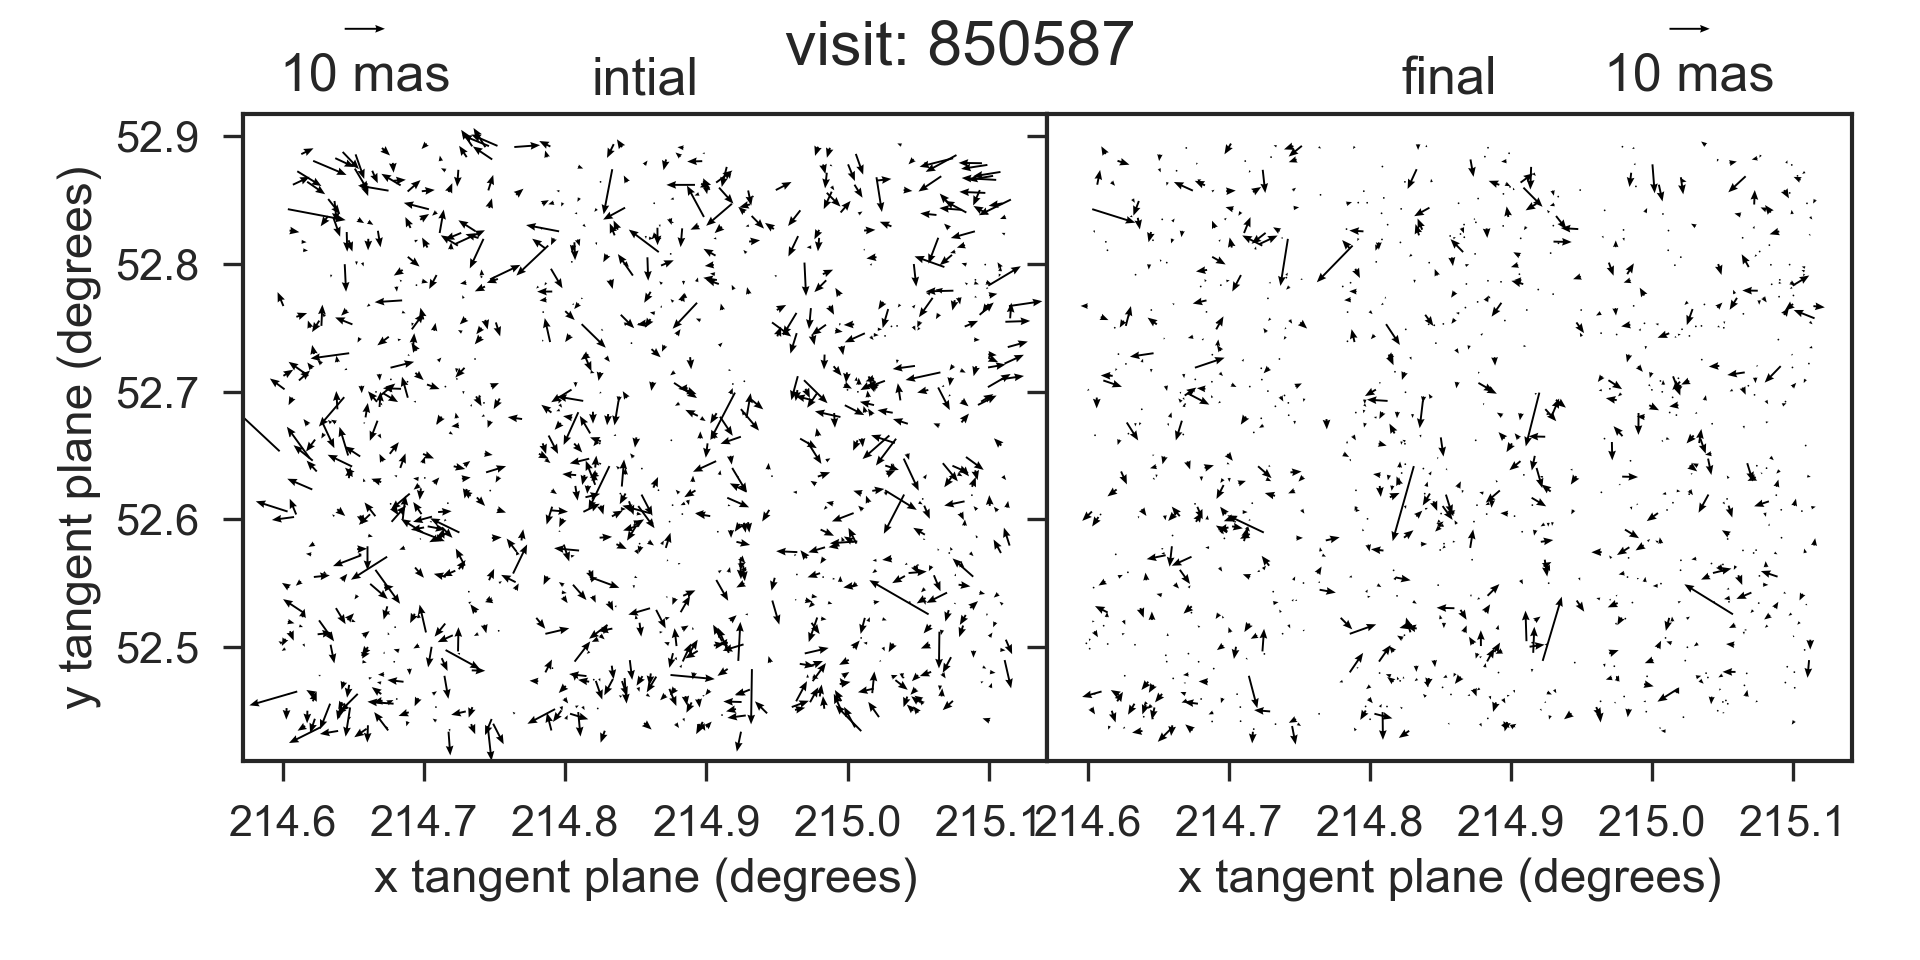

In [33]:
plot_tangentplane_residuals(initial, final, scale=2)

### residuals vs. star magnitude per visit

This is just a check that there is no magnitude-dependent structure in the residuals. The shrinking of the residuals from the simple histograms should be evident here, if you flatten across the x-axis.

849375 initial total, cut x/y: 2334, 1161/1161
849375 final total, cut x/y: 2262, 1068/1073


<IPython.core.display.Javascript object>


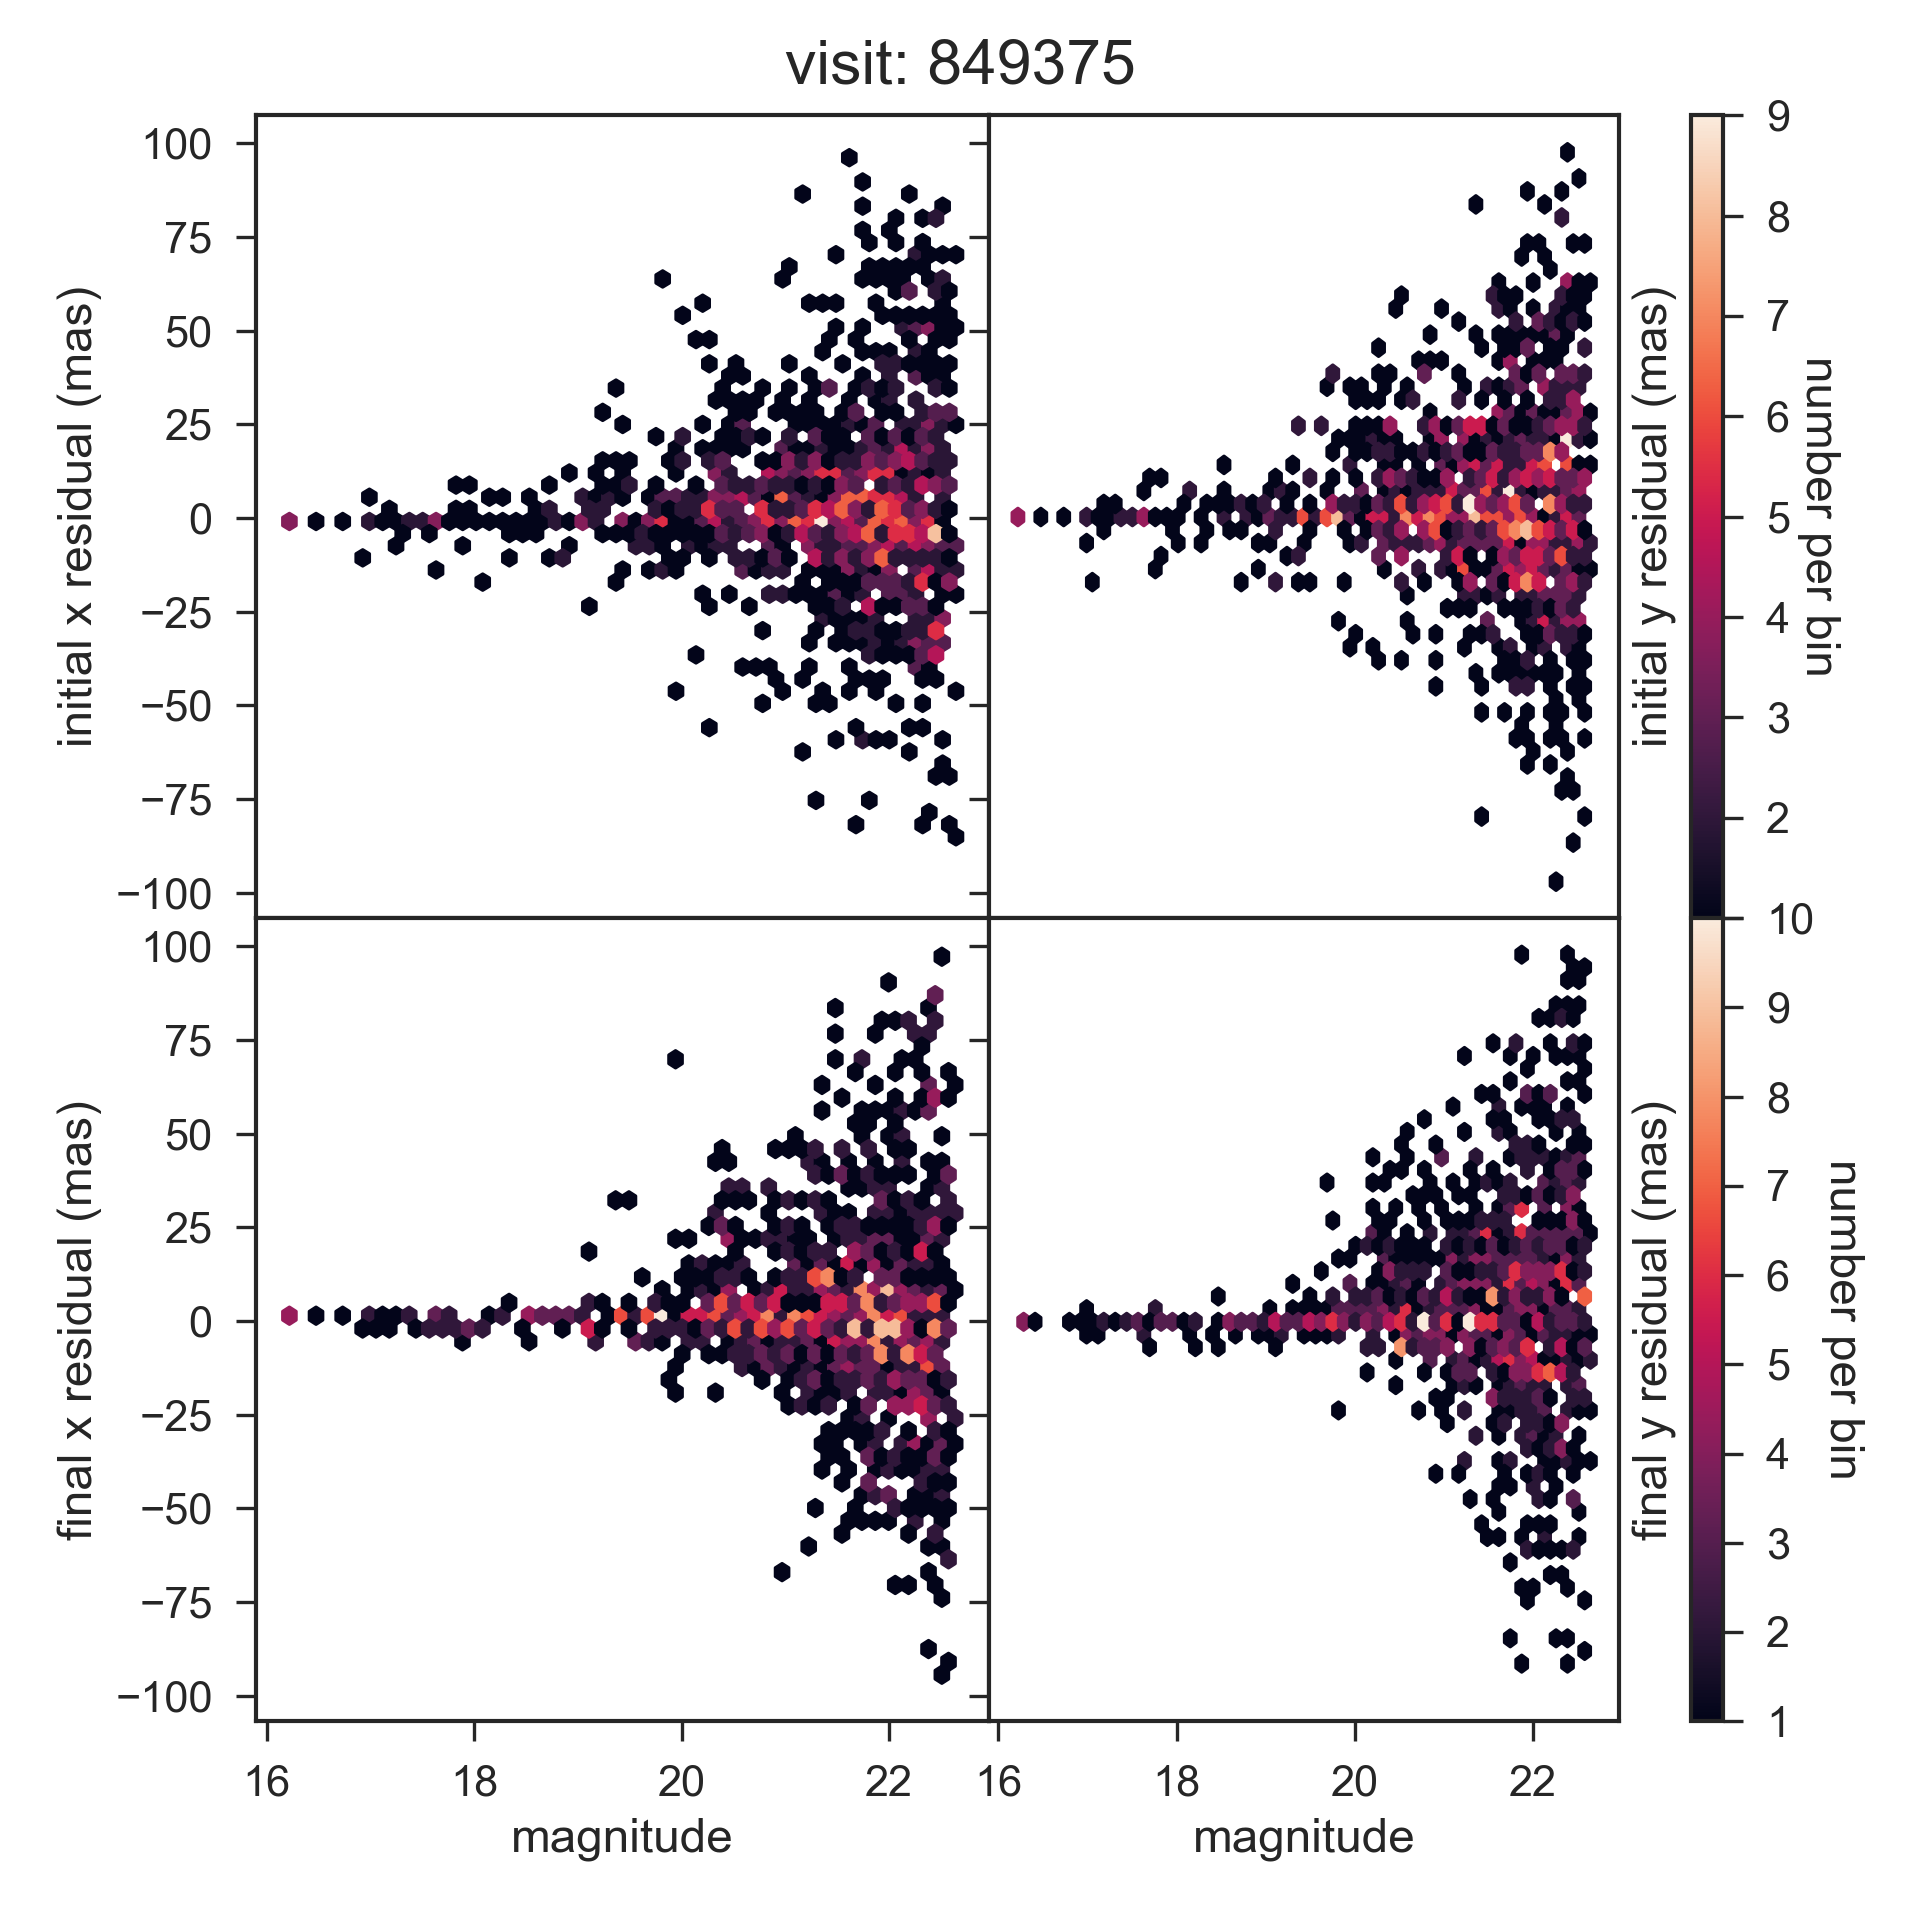

850587 initial total, cut x/y: 2334, 1163/1163
850587 final total, cut x/y: 2262, 1165/1163


<IPython.core.display.Javascript object>


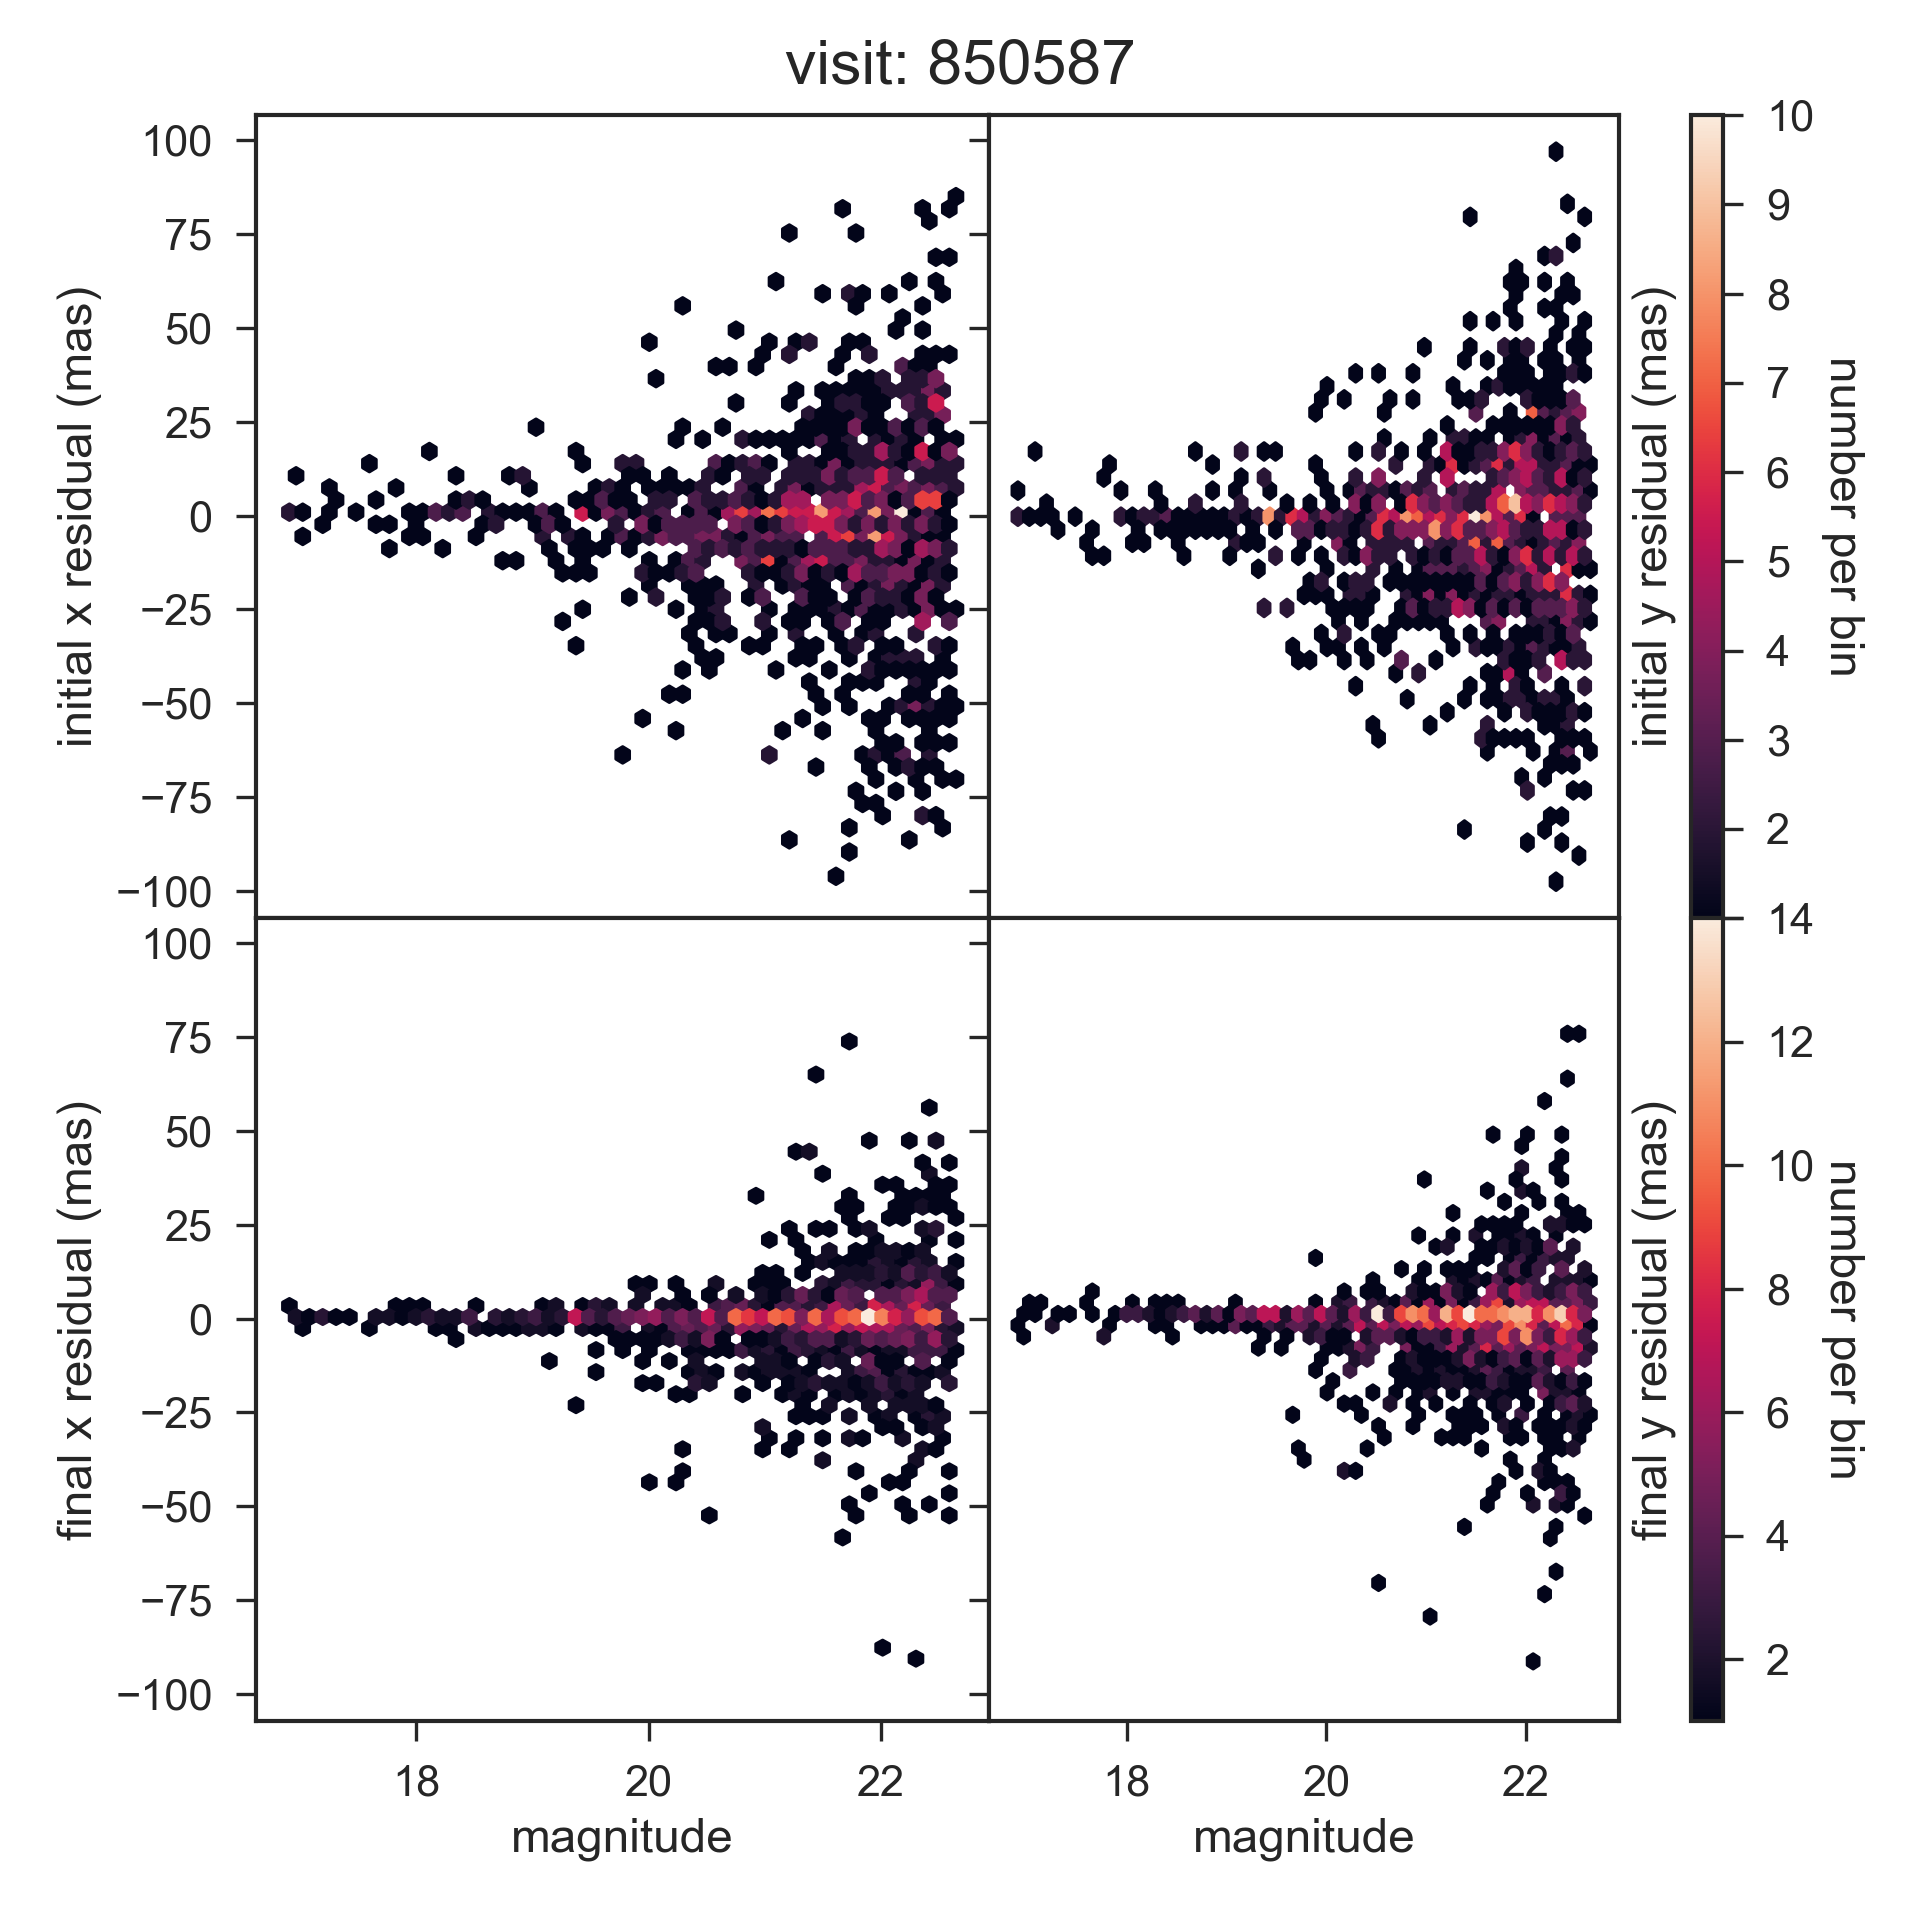

In [12]:
plot_mags(initial, final)

## Playing with pdvega for interactive plots

To use this, you have to install pgvega. I'm not saving executed cells here, because they're huge (they contain the json of all the points). It probably breaks down for full focal plane HSC data, too.
https://jakevdp.github.io/pdvega/installation.html

In [7]:
import pdvega

In [ ]:
final.to_pandas().vgplot.scatter(x='rx',y='ry')#,gridsize=100)